# AV: Bigmart Sales Prediction - Solution 7

In [578]:
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, Imputer, PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, RANSACRegressor, Ridge
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [520]:
data = pd.read_csv('Train_UWu5bXk.csv')
test = pd.read_csv("Test_u94Q5KV.csv")

In [521]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [522]:
features = ['Item_MRP', 'Item_MRP_squared']
target = ['Item_Outlet_Sales']

## Missing Values Treatment - Item_Weight

In [523]:
unique_item_identifier_data = data['Item_Identifier'].unique()
unique_item_identifier_test = test['Item_Identifier'].unique()
print(len(unique_item_identifier_data), len(unique_item_identifier_test)) 

item_identifier_weight_dic1 = {x: np.NaN for x in unique_item_identifier_data}
item_identifier_weight_dic2 = {x: np.NaN for x in unique_item_identifier_test}
item_identifier_weight_dic1.update(item_identifier_weight_dic2)

1559 1543


In [524]:
for j in test.iterrows():
        if not np.isnan(j[1]['Item_Weight']):
            item_identifier_weight_dic1[j[1]['Item_Identifier']] = j[1]['Item_Weight']

for j in data.iterrows():
        if not np.isnan(j[1]['Item_Weight']):
            item_identifier_weight_dic1[j[1]['Item_Identifier']] = j[1]['Item_Weight']

In [525]:
data['Item_Weight'] = data['Item_Identifier']
data['Item_Weight'] = data['Item_Weight'].map(item_identifier_weight_dic1)

In [526]:
test['Item_Weight'] = test['Item_Identifier']
test['Item_Weight'] = test['Item_Weight'].map(item_identifier_weight_dic1)

In [527]:
print(data.isnull().sum())
print(test.isnull().sum())

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64
Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64


## Missing Values Treatment - Item_Fat_Content

In [528]:
print(data['Item_Fat_Content'].unique())
print(test['Item_Fat_Content'].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Low Fat' 'reg' 'Regular' 'LF' 'low fat']


In [529]:
def fun_item_fat_content(x):
    if x == 'Low Fat':
        return 'LF'
    elif x == 'low fat':
        return 'LF'
    elif x =='LF':
        return x
    elif x == 'Regular':
        return 'RG'
    elif x == 'reg':
        return 'RG'

In [530]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].apply(lambda x: fun_item_fat_content(x))
test['Item_Fat_Content'] = test['Item_Fat_Content'].apply(lambda x: fun_item_fat_content(x))

In [531]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,LF,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,RG,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,LF,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,LF,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,13.600,RG,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


## Missing Values Treatment - Item_Type

In [532]:
print(data['Item_Type'].unique())
print(test['Item_Type'].unique())

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['Snack Foods' 'Dairy' 'Others' 'Fruits and Vegetables' 'Baking Goods'
 'Health and Hygiene' 'Breads' 'Hard Drinks' 'Seafood' 'Soft Drinks'
 'Household' 'Frozen Foods' 'Meat' 'Canned' 'Starchy Foods' 'Breakfast']


## Missing Values Treatment - Outlet_Identifier <-> Outlet_Size

In [533]:
print(data['Outlet_Size'].unique())
print(test['Outlet_Size'].unique())
print(data['Outlet_Identifier'].unique())
print(test['Outlet_Identifier'].unique())

['Medium' nan 'High' 'Small']
['Medium' nan 'Small' 'High']
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['OUT049' 'OUT017' 'OUT010' 'OUT027' 'OUT046' 'OUT018' 'OUT045' 'OUT019'
 'OUT013' 'OUT035']


In [534]:
outlet_size_mapping = {'Small': 1, 'Medium': 2, 'High': 3}
data['Outlet_Size'] = data['Outlet_Size'].map(outlet_size_mapping)
test['Outlet_Size'] = test['Outlet_Size'].map(outlet_size_mapping)

In [535]:
outlet_identifier_unique = data['Outlet_Identifier'].unique()
print(outlet_identifier_unique)
outlet_identifier_unique_dic = {x: np.NaN for x in outlet_identifier_unique}
outlet_identifier_unique_dic

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


{'OUT010': nan,
 'OUT013': nan,
 'OUT017': nan,
 'OUT018': nan,
 'OUT019': nan,
 'OUT027': nan,
 'OUT035': nan,
 'OUT045': nan,
 'OUT046': nan,
 'OUT049': nan}

In [536]:
for j in data.iterrows():
        if not np.isnan(j[1]['Outlet_Size']):
            outlet_identifier_unique_dic[j[1]['Outlet_Identifier']] = j[1]['Outlet_Size']

In [537]:
outlet_identifier_unique_dic

{'OUT010': nan,
 'OUT013': 3.0,
 'OUT017': nan,
 'OUT018': 2.0,
 'OUT019': 1.0,
 'OUT027': 2.0,
 'OUT035': 1.0,
 'OUT045': nan,
 'OUT046': 1.0,
 'OUT049': 2.0}

In [538]:
for j in test.iterrows():
        if not np.isnan(j[1]['Outlet_Size']):
            outlet_identifier_unique_dic[j[1]['Outlet_Identifier']] = j[1]['Outlet_Size']
outlet_identifier_unique_dic

{'OUT010': nan,
 'OUT013': 3.0,
 'OUT017': nan,
 'OUT018': 2.0,
 'OUT019': 1.0,
 'OUT027': 2.0,
 'OUT035': 1.0,
 'OUT045': nan,
 'OUT046': 1.0,
 'OUT049': 2.0}

## Visualizing important characteristics of a dataset

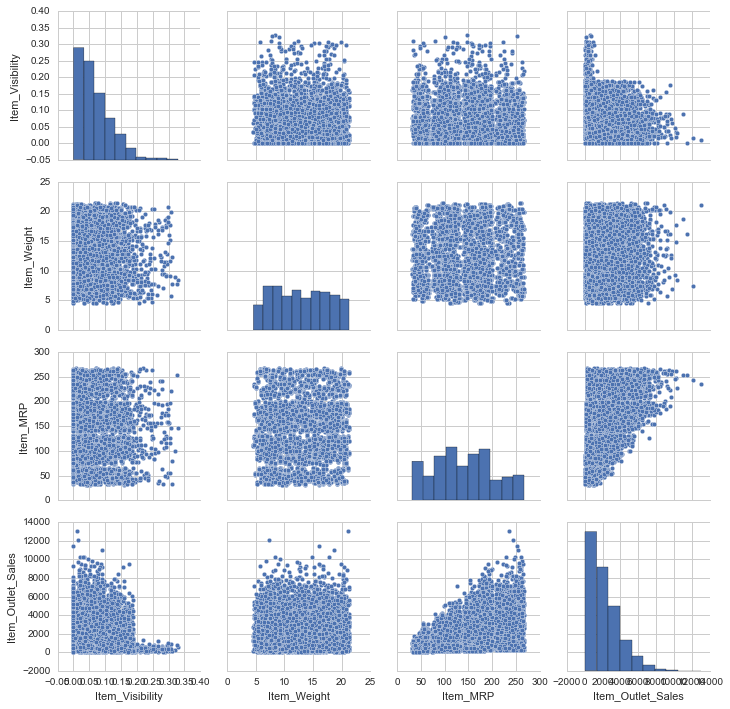

In [539]:
cols = ['Item_Visibility', 'Item_Weight', 'Item_MRP', 'Item_Outlet_Sales']
df = data[cols]
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, size=2.5)
plt.show()

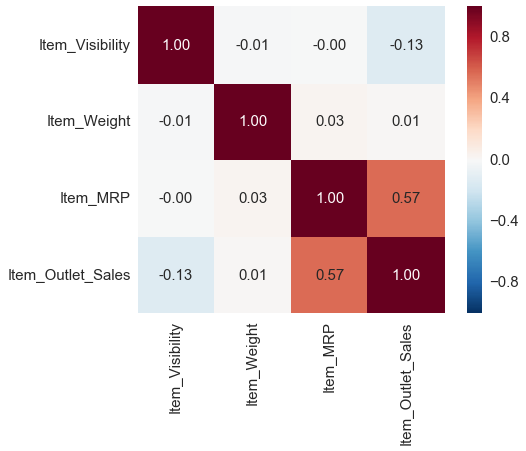

In [540]:
cm = np.corrcoef(df.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.show()

## Preparing for training

In [541]:
data['Item_MRP_squared'] = data['Item_MRP'].apply(lambda x: np.square(x))
test['Item_MRP_squared'] = test['Item_MRP'].apply(lambda x: np.square(x))

In [542]:
print(data.columns)
X = data[features]
y = data['Item_Outlet_Sales']
X_test = test[features]

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_MRP_squared'],
      dtype='object')


## Imputing missing values
Note: features with null values has not been taken in the first round

In [543]:
X.isnull().sum()

Item_MRP            0
Item_MRP_squared    0
dtype: int64

In [544]:
X_test.isnull().sum()

Item_MRP            0
Item_MRP_squared    0
dtype: int64

In [545]:
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)
X.head()

,Item_MRP,Item_MRP_squared
0,249.8092,62404.636405
1,48.2692,2329.915669
2,141.6180,20055.657924
3,182.0950,33158.589025
4,53.8614,2901.050410


In [546]:
X_test.head()

,Item_MRP,Item_MRP_squared
0,107.8622,11634.254189
1,87.3198,7624.747472
2,241.7538,58444.899814
3,155.0340,24035.541156
4,234.2300,54863.692900


## Scaling the data

In [547]:
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [548]:
X[0]

array([ 1.74745381,  2.08876601])

## Dividing the data in training and validation set

In [549]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

## Training

In [550]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Predictions

In [551]:
predictions = model_lr.predict(X_val)
print(model_lr.score(X_val, y_val))
model_lr.score(X_train, y_train)

0.326765422336


0.32090136989865869

## Writing the submission file

In [552]:
model_lr = LinearRegression()
model_lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [553]:
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50, residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                         residual_threshold=5.0, random_state=0)

In [574]:
ridge = Ridge(alpha=.001)
ridge.fit(X, y)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [555]:
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, max_trials=100,
        min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x0000022F5A1C90D0>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

In [556]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

In [557]:
#lin_regplot(X, y, model_lr)

In [575]:
print(model_lr.coef_, model_lr.intercept_)
print(ridge.coef_, ridge.intercept_)

[ 1031.71536668   -64.78199789] 2181.28891358
[ 1031.71269281   -64.77938144] 2181.28891358


In [576]:
#predictions = model_lr.predict(X_test)
#predictions = ransac.predict(X_test)
predictions = ridge.predict(X_test)

In [577]:
result = test[['Item_Identifier', 'Outlet_Identifier']]
result['Item_Outlet_Sales'] = pd.Series(predictions, index=result.index)
result.to_csv('submission.csv', index = False, index_label = 'Id' )

C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
